In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('bmh')

In [5]:
df_ozon = pd.read_csv('C:/Users/User/projects/Marketplace/OZON Тетчер 02_2022-07_2023.csv',index_col=[0], parse_dates=[0])


In [6]:
df_revenue = df_ozon[['revenue']]


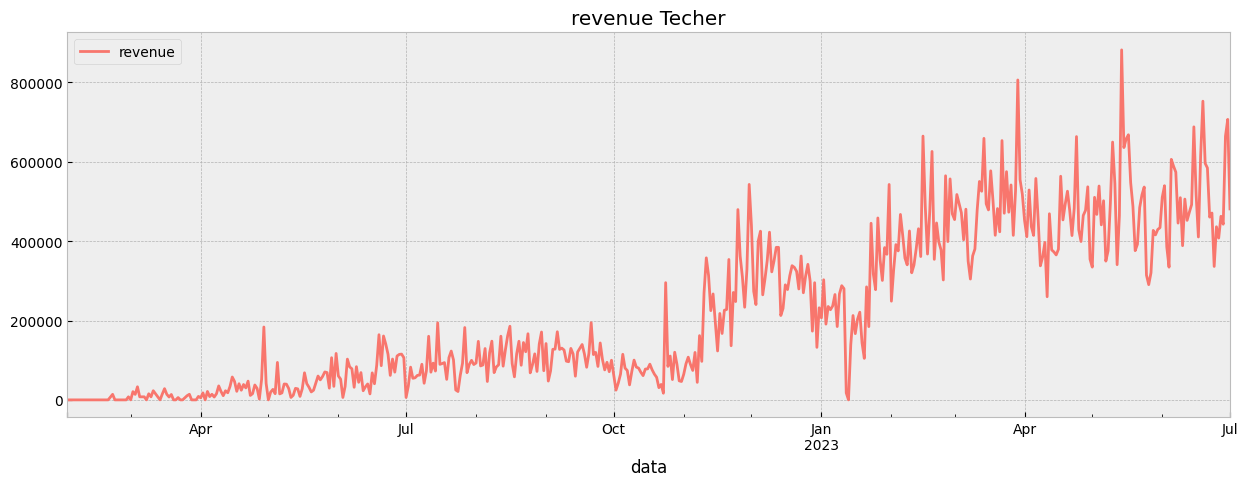

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_revenue.plot(style='-', figsize=(15,5), color=color_pal[0], title='revenue Techer')

In [10]:
train = df_revenue.loc[(df_revenue.index < '2023-06-01') & (df_revenue.index  > '2023-04-01')]
test = df_revenue.loc[df_revenue.index >= '2023-06-01']

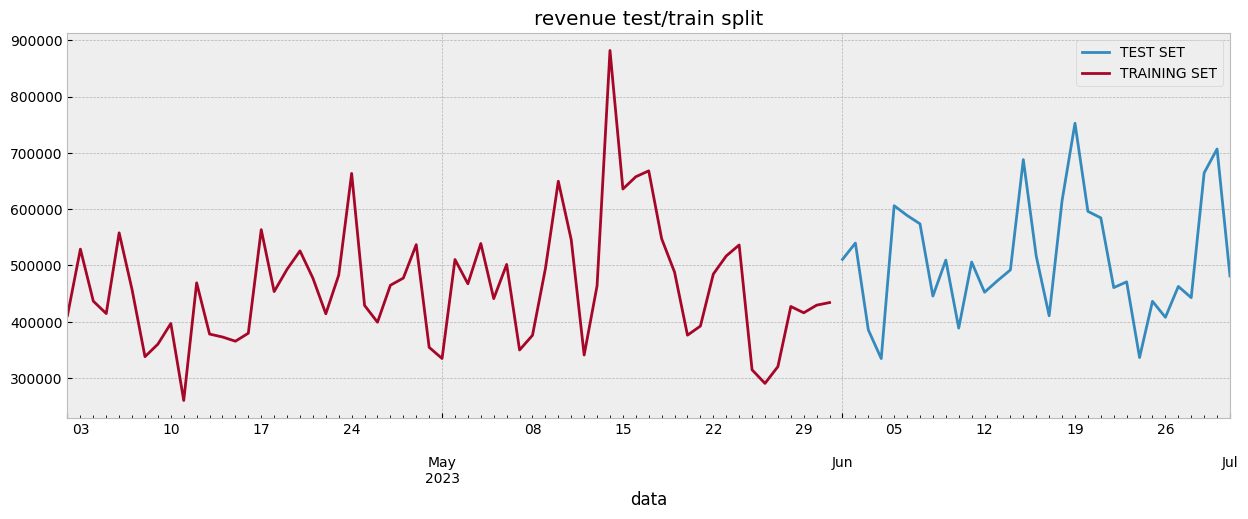

In [12]:
_ = test \
    .rename(columns={'revenue': 'TEST SET'}) \
    .join(train.rename(columns={'revenue': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='revenue test/train split', style='-')

In [16]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [18]:
df_features = create_features(df_revenue)


C:\Users\User\AppData\Local\Temp\ipykernel_12936\3358930272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
C:\Users\User\AppData\Local\Temp\ipykernel_12936\3358930272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
C:\Users\User\AppData\Local\Temp\ipykernel_12936\3358930272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [20]:
X_train = train['id']
y_train = train['revenue']

X_test = test['id']
y_test = test['revenue']

KeyError: 'id'

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'revenue'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
X_train

,dayofyear,hour,dayofweek,quarter,month,year
id,,,,,,
2023-02-02,33,0,3,1,2,2023
2023-02-03,34,0,4,1,2,2023
2023-02-04,35,0,5,1,2,2023
2023-02-05,36,0,6,1,2,2023
2023-02-06,37,0,0,1,2,2023
...,...,...,...,...,...,...
2023-05-27,147,0,5,2,5,2023
2023-05-28,148,0,6,2,5,2023
2023-05-29,149,0,0,2,5,2023


In [21]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

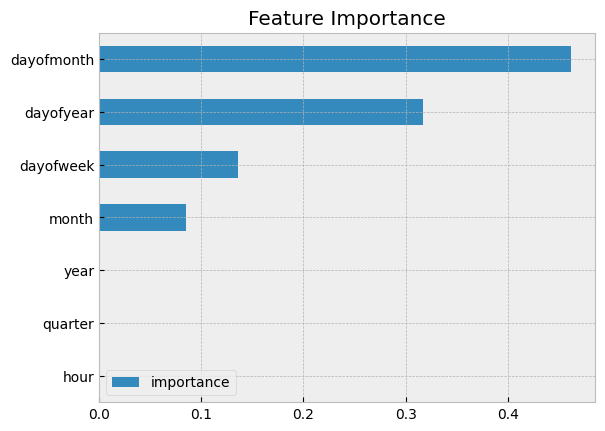

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [24]:
test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)

C:\Users\User\AppData\Local\Temp\ipykernel_12936\3035063797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['MW_Prediction'] = reg.predict(X_test)


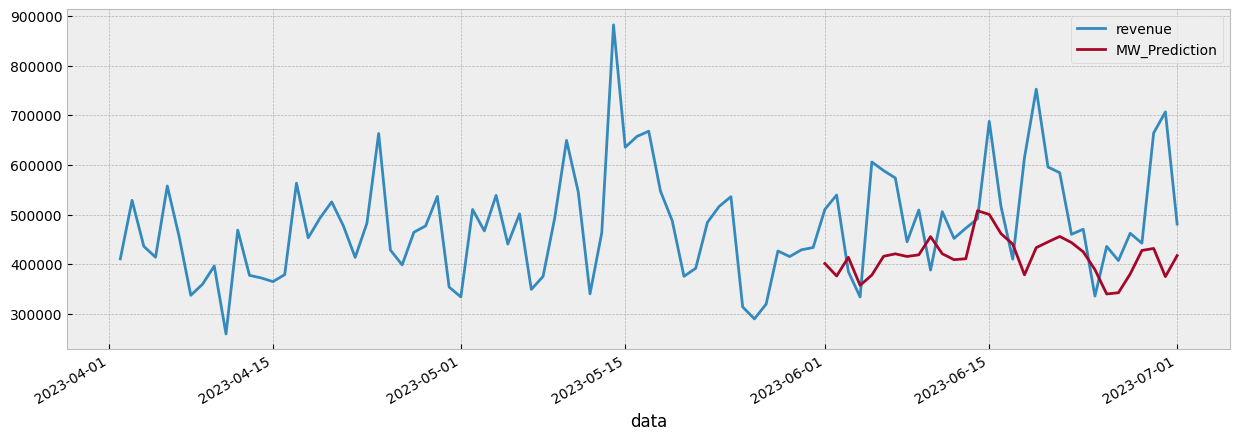

In [25]:
_ = pjme_all[['revenue','MW_Prediction']].plot(figsize=(15, 5))

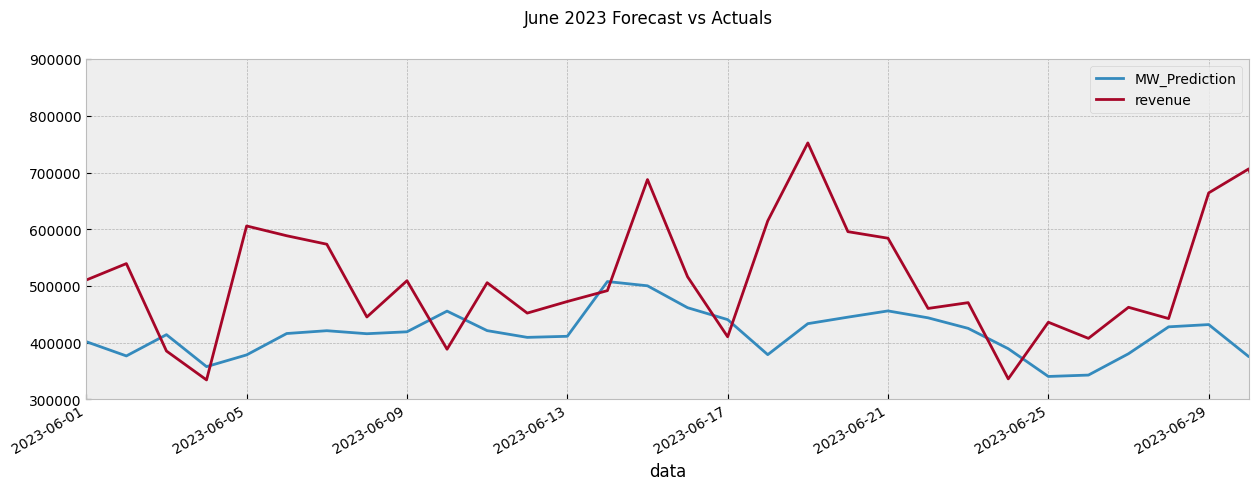

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','revenue']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='2023-06-01', upper='2023-06-30')
ax.set_ylim(300000, 900000)
plot = plt.suptitle('June 2023 Forecast vs Actuals')